In [97]:
#!pip install splink

In [69]:
import pandas as pd

In [70]:
df = pd.read_csv('/Users/raphaelcourivaud/Downloads/Matching Propriétaires Feuille 1.csv')

In [71]:
df_scores = pd.DataFrame()
cols = df.filter(regex='score').columns
for col in cols:
    df_ = df[[col, "validation"]].query("validation.notnull()").copy()
    df_["which_score"] = col
    df_ = df_.rename(columns={col: "score"})
    df_scores = pd.concat([df_scores, df_])

In [72]:
import seaborn as sns

[Text(0, 0, 'owner_fullname_score'),
 Text(1, 0, 'owner_firstname_score'),
 Text(2, 0, 'owner_last_name_score'),
 Text(3, 0, 'owner_birth_date_score'),
 Text(4, 0, 'owner_city_score'),
 Text(5, 0, 'owner_postal_code_score'),
 Text(6, 0, 'owner_address_score')]

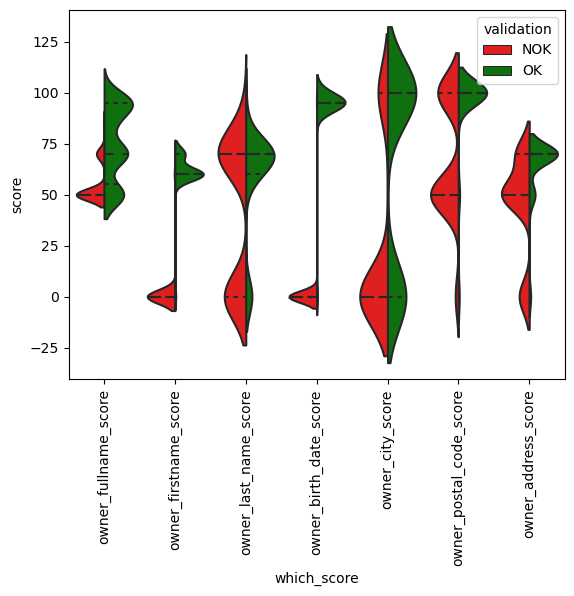

In [73]:
# turn x label vertically
ax = sns.violinplot(data=df_scores.query("validation != 'VERIFY'"), x="which_score", y="score", hue="validation",
               split=True, inner="quart", fill=False,
               palette={"OK": "green", "NOK": "red"},
                scale="count", 
            
                )
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [75]:
df_X = df.query("validation.notnull()  and validation != 'VERIFY'").copy()

In [76]:
X = df_X.filter(regex='score').values
y = df_X["validation"].map({"OK": 1, "NOK": 0}).values

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [78]:
lg = LogisticRegression()
lg.fit(X_train, y_train)

LogisticRegression()

In [79]:
probas = lg.predict_proba(X_test)[:, 1]

In [80]:
from sklearn.metrics import roc_auc_score, classification_report

print(classification_report(y_test, probas > 0.5))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        47
           1       0.98      0.98      0.98        52

    accuracy                           0.98        99
   macro avg       0.98      0.98      0.98        99
weighted avg       0.98      0.98      0.98        99



Text(0.5, 0, 'Relative Feature Importance')

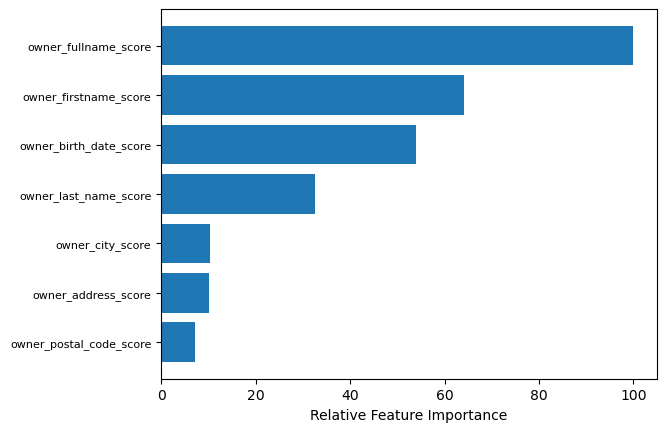

In [81]:
# Display feature importance in seaborn


import numpy as np
import matplotlib.pyplot as plt

feature_importance = np.abs(lg.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(df.filter(regex='score').columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')


In [82]:
# Display where the model is wrong

df_X["proba"] = lg.predict_proba(X)[:, 1]
df_X["pred"] = df_X["proba"] > 0.5

df_X["pred"] = df_X["pred"].map({True: "OK", False: "NOK"})
df_X["validation"] = df_X["validation"].map({"OK": "OK", "NOK": "NOK"})
df_X["error"] = df_X["pred"] != df_X["validation"]

df_X.query("error").filter(regex='name|score|validation|proba').head(10)

,prod_full_name,ff_fullname (ddenom),ff_firstname (dprnus),ff_lastname (dnomus),owner_fullname_score,owner_firstname_score,owner_last_name_score,owner_birth_date_score,owner_city_score,owner_postal_code_score,owner_address_score,validation,proba
68,DEHU ANDRE FRANCOIS,DEHU/FRANCOIS HENRI,FRANCOIS,DEHU,70,60,70,0,0,50,0,OK,0.210852
212,GIRARD MARCEL EMILE,BARBIER/MARCELLE EMILIENNE,MARCELLE,GIRARD,70,70,70,0,100,100,70,NOK,0.664734
332,DEVILLE PHILIPPE YVON,DEVILLE/YVON,YVON,DEVILLE,85,60,70,0,0,50,50,NOK,0.545056
345,M GOY CLEMENT,GOY/CLEMENT RENE,CLEMENT,GOY,50,60,70,0,50,100,50,OK,0.022701
387,MME PHILIBERT JEANNE,CHARCE/JEANNE PAULETTE EMMA,JEANNE,PHILIBERT,50,60,70,95,0,100,50,NOK,0.959766
